# ***Sweeft | Acceleration***

## ***Data Science Technical Exam***

#### ***Maya Demurovi &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 07.02.2025***

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
df = pd.read_csv("customer_analysis (1).csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


<br><br>

### ***Data Understanding and Cleaning***

In [48]:
print(df.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [49]:
print(df.duplicated().sum())

0


In [50]:
df_cleaned = df.dropna()

##### *To understand the data better, let's check the correlations between features, converting some categorical features into numericals with one-hot encoding option*

In [51]:
df_converted = pd.get_dummies(df_cleaned, columns=['Education', 'Marital_Status'], drop_first=True)
df_converted['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df_converted.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,...,True,False,False,False,False,False,True,False,False,False
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,...,True,False,False,False,False,False,True,False,False,False
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,True,False,False,False,False,False,False,True,False,False
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,...,True,False,False,False,False,False,False,True,False,False
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,False,False,True,False,False,True,False,False,False,False


In [52]:
corr_matrix = df_converted.corr()

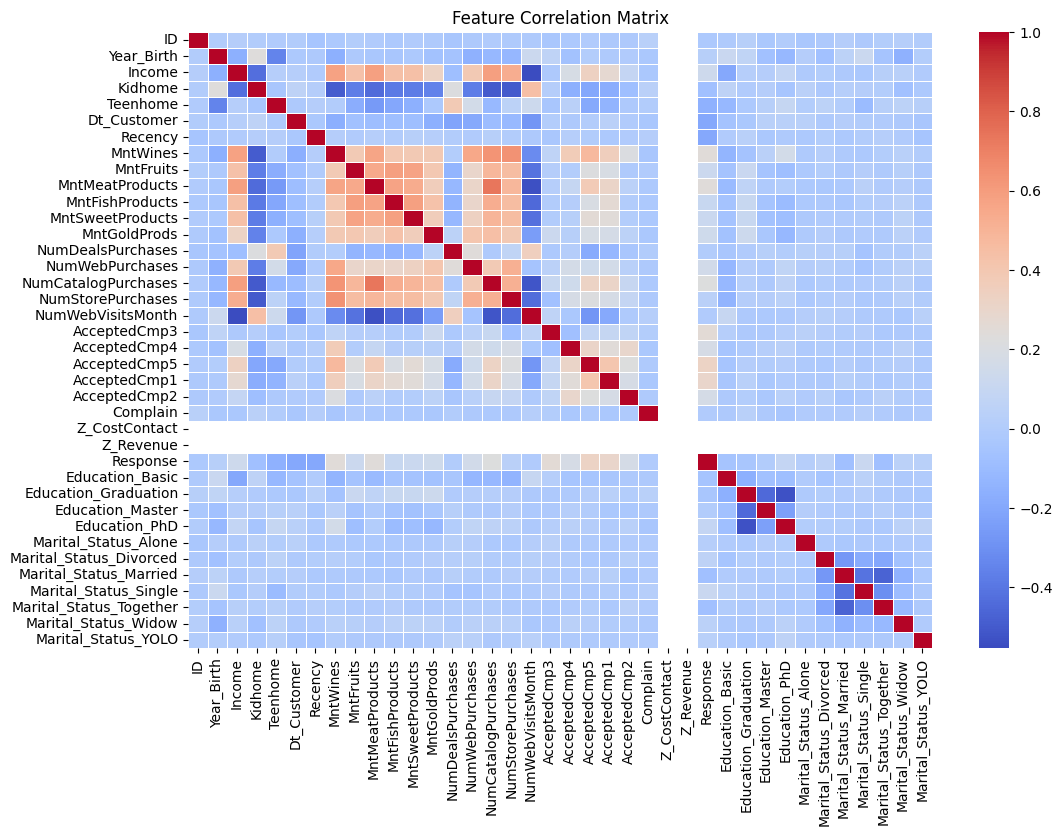

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [54]:
threshold = 0.5
high_corr_pairs = (corr_matrix.abs() > threshold) & (corr_matrix.abs() < 1)
high_corr_df = corr_matrix[high_corr_pairs].stack().reset_index()
high_corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False)

In [55]:
high_corr_df.head(10)

,Feature 1,Feature 2,Correlation
34,NumCatalogPurchases,MntMeatProducts,0.734127
20,MntMeatProducts,NumCatalogPurchases,0.734127
40,NumStorePurchases,MntWines,0.640012
11,MntWines,NumStorePurchases,0.640012
33,NumCatalogPurchases,MntWines,0.634753
10,MntWines,NumCatalogPurchases,0.634753
22,MntFishProducts,MntFruits,0.593431
13,MntFruits,MntFishProducts,0.593431
2,Income,NumCatalogPurchases,0.589162
31,NumCatalogPurchases,Income,0.589162


In [56]:
sorted_pairs = []
for i in range(len(high_corr_df)):
    feature_1 = high_corr_df.iloc[i]['Feature 1']
    feature_2 = high_corr_df.iloc[i]['Feature 2']
    sorted_pairs.append(tuple(sorted([feature_1, feature_2])))

high_corr_df['sorted_features'] = sorted_pairs
high_corr_df = high_corr_df.drop_duplicates(subset=['sorted_features'])
high_corr_df = high_corr_df.drop(columns=['sorted_features'])
high_corr_df = high_corr_df.reset_index(drop=True)

high_corr_df

,Feature 1,Feature 2,Correlation
0,NumCatalogPurchases,MntMeatProducts,0.734127
1,NumStorePurchases,MntWines,0.640012
2,NumCatalogPurchases,MntWines,0.634753
3,MntFishProducts,MntFruits,0.593431
4,Income,NumCatalogPurchases,0.589162
5,MntMeatProducts,Income,0.584633
6,MntFishProducts,MntSweetProducts,0.583867
7,Income,MntWines,0.578650
8,MntFishProducts,MntMeatProducts,0.573574
9,MntFruits,MntSweetProducts,0.571606


##### *The dataset reveals several interesting correlations between features, with most relationships being positive. Notably, the highest correlation is between NumCatalogPurchases and MntMeatProducts (0.73), suggesting that customers who purchase more catalog items tend to also buy more meat products. Other strong correlations include NumStorePurchases and MntWines (0.64), and between Income and NumCatalogPurchases (0.59), indicating that higher income is often linked with increased catalog purchases. A few negative correlations are also present, like between NumStorePurchases and Kidhome (-0.50) and Income with NumWebVisitsMonth (-0.55), which may indicate that customers with more kids tend to make fewer store purchases, and higher-income individuals might browse online less frequently...*

##### *what’s more interesting is how data helps solve real-world problems like **targeted marketing**. Businesses can use these insights to personalize promotions, predict trends, and optimize sales strategies...*

<br><br>

### ***First Task:***

### ***Targeted Marketing***  <span style="font-size:80%;">*or How to Reach the Right Audience*</span>

##### *Let's assume we're selling wine and we want to advertise it to only 500 people out of 2000 from data we have. We need to figure out who would be most likely to buy the wine based on their behavior and characteristics. We'll use clustering to group customers by things like their income, buying habits and interests. By targeting the right clusters, we can make sure our marketing is as effective...*

In [57]:
mnt_wines_corr = corr_matrix['MntWines'].sort_values(ascending=False)
mnt_wines_corr

MntWines                   1.000000
NumStorePurchases          0.640012
NumCatalogPurchases        0.634753
Income                     0.578650
MntMeatProducts            0.568860
NumWebPurchases            0.553786
AcceptedCmp5               0.473550
MntFishProducts            0.397721
MntGoldProds               0.392731
MntSweetProducts           0.390326
MntFruits                  0.387024
AcceptedCmp4               0.373143
AcceptedCmp1               0.351417
Response                   0.246299
AcceptedCmp2               0.206185
Education_PhD              0.159450
AcceptedCmp3               0.061463
Education_Master           0.036722
Marital_Status_Widow       0.034667
Marital_Status_Divorced    0.020029
Recency                    0.015721
NumDealsPurchases          0.008886
Marital_Status_Together    0.005799
Teenhome                   0.003747
Marital_Status_YOLO        0.001507
Marital_Status_Married    -0.012330
Marital_Status_Alone      -0.013147
ID                        -0

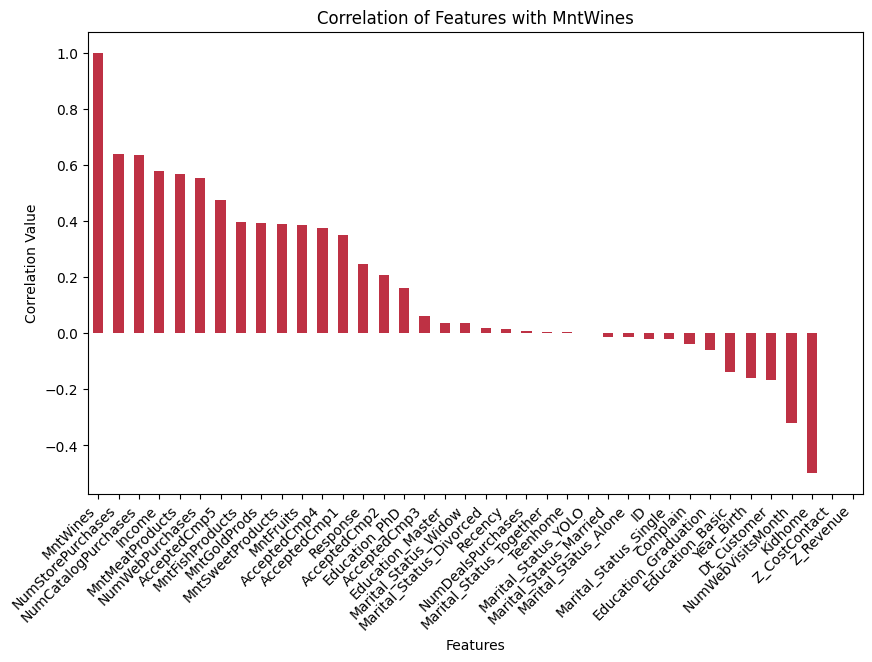

In [58]:
plt.figure(figsize=(10, 6))
mnt_wines_corr.plot(kind='bar', color='#BE3144')
plt.title('Correlation of Features with MntWines')
plt.xlabel('Features')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45, ha='right')
plt.show()

##### *We see that the strongest influence comes from features like **NumStorePurchases**, **Income**, and **MntMeatProducts**, among others. Let's focus on these key features for clustering analysis*

##### *Let's standardize the data using StandardScaler to ensure all features are on the same scale, as we will use the K-Means algorithm*

In [129]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_converted[['MntWines', 'Income', 'NumStorePurchases', 'MntMeatProducts']])

In [130]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(df_scaled)

In [131]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.reset_index(drop=True, inplace=True)
df_scaled['Cluster'] = clusters

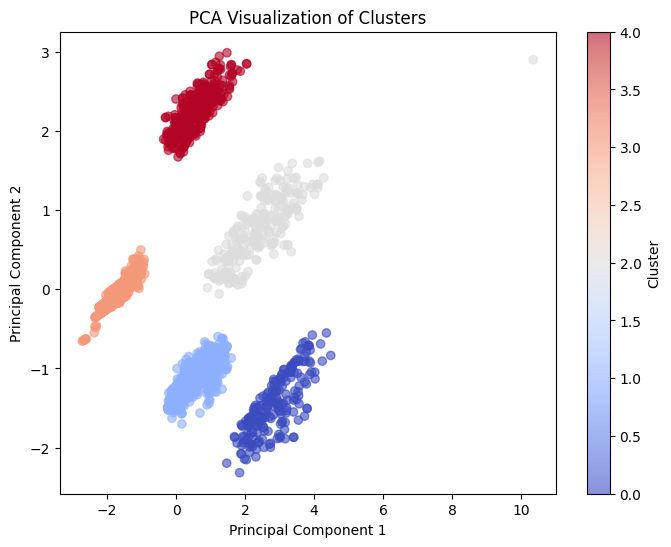

In [132]:
df_scaled.columns = df_scaled.columns.astype(str)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [133]:
df_converted['Cluster'] = clusters
cluster_summary = df_converted.groupby('Cluster').mean()
cluster_summary[['MntWines', 'Income', 'NumStorePurchases', 'MntMeatProducts']]

,MntWines,Income,NumStorePurchases,MntMeatProducts
Cluster,,,,
0,988.356808,72645.704225,8.000000,278.455399
1,285.301848,57826.110883,5.932238,117.034908
2,608.880000,82435.040000,7.933333,695.302222
3,35.495327,32690.173416,3.049844,21.928349
4,473.905488,67428.466463,10.792683,232.304878


##### *By analyzing the clusters, we can identify which groups represent specific behaviors, like spending on wine, income levels, or purchase frequency. This helps us predict which groups are most likely to respond to targeted ads, allowing us to focus on those with the highest potential impact*

### ***Observations:***

##### ***Cluster 2 (High Store Activity, High Income)***
##### *MntWines: High*
##### *Income: High*
##### *NumStorePurchases: High*
##### *MntMeatProducts: High*
##### *Observation: This group shows high income and high spending across wines, meat products, and store activity. They are likely frequent buyers and good candidates for loyalty programs or personalized offers.*

- - - -

##### ***Cluster 0 (High Spending, Higher Income)***
##### *MntWines: Very high*
##### *Income: High*
##### *NumStorePurchases: Moderate*
##### *MntMeatProducts: Very high*
##### *Observation: This group is wealthier and spends significantly on wines and meat products. Targeting premium products and high-quality offerings would be effective for this cluster.*

___  ___  ___  ___

##### ***So Clusters 0 and 2 would be key groups for us as wine sellers...***

In [134]:
target_clusters = [0, 2]
targeted_ids = df_converted[df_converted['Cluster'].isin(target_clusters)]['ID'].reset_index(drop=True)
print("TARGETED ID\n" + "-"*6)
print(targeted_ids.to_string(index=False))

TARGETED ID
------
 5524
 2114
 6565
 5376
 1993
 1966
 8601
 4114
 2225
 6260
 6853
 1357
 1402
 1859
 7503
 8504
 8908
 7431
 1592
11071
 1685
  821
11084
 8690
 7055
10240
 9260
10095
 8475
 8717
10314
 6982
 9938
 6422
10424
 2798
  380
    0
 6274
 2075
  460
 5341
  313
 9529
 6439
 2176
 9265
 8867
 8932
  309
 2379
 3762
10102
 4543
 2926
 6320
 9750
 7214
10675
 7381
 9560
 1150
10172
 9707
  175
 9185
 9365
 6184
 7274
 5125
 5955
 2928
 1245
 1729
 8318
 3428
 7030
 7106
 5067
 4216
 1361
 6932
 1340
 8746
 3725
 1137
 4947
10648
 2416
 7999
 5172
 3403
10965
11088
 5140
 6036
  203
 3711
 2532
 4943
 4322
 4702
 5547
10955
 8314
 3174
 3179
 9120
 2574
 9058
 7627
 4501
 7972
  988
10156
 4299
10727
 8923
 6945
 1907
  701
 4149
 2131
 1173
 4611
 4248
 2920
 4673
 4910
 6327
 9826
 1501
 7279
 6384
 8029
 6988
10479
 3619
 5114
10936
 6086
10430
 7875
 5564
 5682
 3560
 4073
 6974
 3667
 7723
 4012
 5909
 5331
 1915
 4964
10736
 3194
 6543
10446
 3749
 3483
 9145
 6303
 94

<br><br>

### ***Second Task:***

### ***Website Conversion Analysis***  <span style="font-size:80%;">*or Visitor-to-Customer Journeys*</span>

##### *In this analysis, we will calculate the website conversion rate by comparing the number of purchases (NumWebPurchases) to the website visits (NumWebVisitsMonth). Since the exact time period for purchases is unclear, we will assume that the purchase data spans over 2 years. Using this assumption, let's estimate the overall conversion rate by calculating the total visits and purchases*

##### *First, let's look at the ratio of purchases from different places to ensure that the website is meaningful*

In [65]:
purchase_counts = {
    "Website": df_converted["NumWebPurchases"].sum(),
    "Catalog": df_converted["NumCatalogPurchases"].sum(),
    "Store": df_converted["NumStorePurchases"].sum()
}

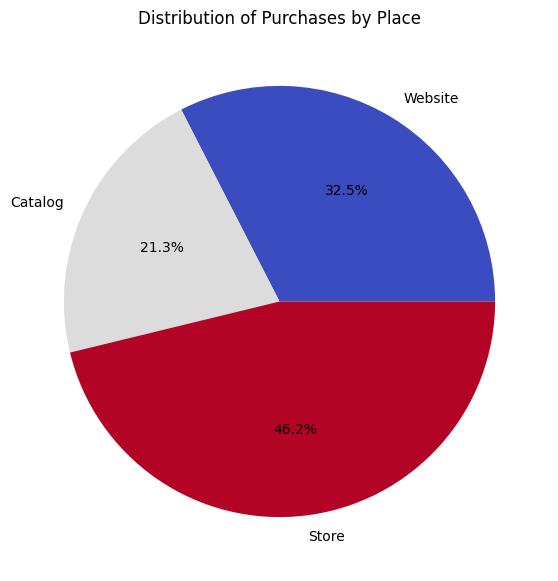

In [66]:
plt.figure(figsize=(7, 7))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(purchase_counts)))
plt.pie(purchase_counts.values(), labels=purchase_counts.keys(), autopct='%1.1f%%', colors=colors)
plt.title("Distribution of Purchases by Place")
plt.show()

In [67]:
df_converted["Estimated_Total_Visits"] = df_converted["NumWebVisitsMonth"] * 24
df_converted["Website_Conversion"] = df_converted["NumWebPurchases"] / df_converted["Estimated_Total_Visits"]
df_converted[["NumWebPurchases", "NumWebVisitsMonth", "Estimated_Total_Visits", "Website_Conversion"]].head()

,NumWebPurchases,NumWebVisitsMonth,Estimated_Total_Visits,Website_Conversion
0,8,7,168,0.047619
1,1,5,120,0.008333
2,8,4,96,0.083333
3,2,6,144,0.013889
4,5,5,120,0.041667


In [68]:
df_converted["Website_Conversion"] = df_converted["Website_Conversion"].replace([float('inf'), -float('inf')], float('nan'))
average_conversion_rate = df_converted["Website_Conversion"].mean()
print(average_conversion_rate)

0.04510274019275206


##### *The website conversion rate of 0.04 (4%) is unusually low, especially compared to the typical 0.2–0.3 range for successful site, also given that 32% of total purchases come from the website, so maybe this unmatching occures, because the data is halfway fictional*

<br><br>

### ***Third Task:***

### ***The Funnel Effect***  <span style="font-size:80%;">*or From Campaign Acceptance to Final Response*</span>

##### *Let's say we're running a series of marketing campaigns. Some customers accept early offers, while others wait until the final campaign to decide. We want to understand how previous campaign acceptances influence the final response*

##### *We will split the data into a training set and a test set, The target variable is **Response**, and the predictors will be the columns **AcceptedCmp1** through **AcceptedCmp5**. However before we start building the model, let's take some steps to investigate the imbalance in the target variable*

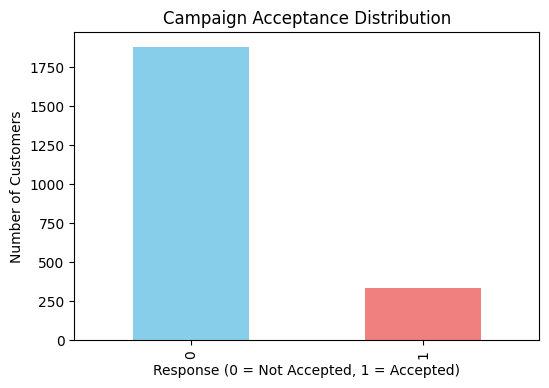

In [69]:
response_counts = df_converted['Response'].value_counts()
plt.figure(figsize=(6,4))
response_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Campaign Acceptance Distribution')
plt.xlabel('Response (0 = Not Accepted, 1 = Accepted)')
plt.ylabel('Number of Customers')
plt.show()

##### *Since there are significantly more customers who did not accept the final campaign compared to those who did, and this imbalance could affect model performance, I already tried different models like Logistic Regression and Random Forest, also experimented with different techniques such as resampling the data and adjusting class weights to improve predictions. However, the best accuracy was achieved using XGBoost, making it the most effective model for this task...*

In [70]:
X = df_converted[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']]
y = df_converted['Response']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scale_pos_weight = len(y_train) / (2 * sum(y_train))

In [72]:
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight, eval_metric='logloss' 
)

In [73]:
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [74]:
print("Report for XGBoost Model:")
print(classification_report(y_test, y_pred_xgb))

Report for XGBoost Model:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       569
           1       0.45      0.49      0.47        96

    accuracy                           0.84       665
   macro avg       0.68      0.69      0.69       665
weighted avg       0.85      0.84      0.84       665



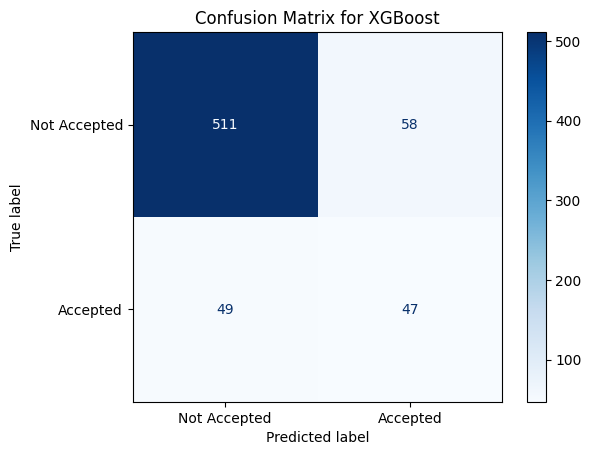

In [75]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Accepted", "Accepted"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost")
plt.show()


##### *So this model with accuracy 84% is quete effective if our primary objective is minimizing costs by avoiding targeting uninterested customers, but if our goal is identifying potential customers who will accept the campaign, model might needs improvements...*